# Memcached Microbenchmarks
Functions to load and plot memcached data

In [1]:
%matplotlib notebook

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('seaborn-paper')

In [2]:
import dpkt
import os
import struct
import numpy as np
import pandas as pd
from collections import defaultdict
from pprint import pprint
from collections import namedtuple

In [3]:
memo = lambda x: x
try:
    from Memoizer import memoize_to_folder
    memo = memoize_to_folder('new_mcd_memoization')
except Exception as e:
    print("Warning: could not load memoizer")

In [4]:
HAS_RAY=False

In [5]:
try:
    import ray
    ray.shutdown()
    ray.init(num_cpus=12)
    HAS_RAY=True
except Exception as e:
    print("Warning: Could not load ray: %s" % e)

2019-09-18 17:02:26,120	WARNING worker.py:1373 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-09-18 17:02:26,146	INFO node.py:498 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-09-18_17-02-26_123373_12490/logs.
2019-09-18 17:02:26,287	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:15948 to respond...
2019-09-18 17:02:26,569	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:24417 to respond...
2019-09-18 17:02:26,575	INFO services.py:809 -- Starting Redis shard with 5.89 GB max memory.
2019-09-18 17:02:26,627	INFO node.py:512 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-09-18_17-02-26_123373_12490/logs.


In [6]:
KEYLEN=8

# PktTime defines the columns of the output of read_memcached_pcap
PktTime = namedtuple('pkt_time', ( 'type', 'key', 'time', 'hit'))

@memo
def read_memcached_pcap(out_dir, dst_mac_is_ts = True, compare_counters = True, force_ipv4=True):
    ''' Reads the moongen pcap file in the provided output directory.
    Assumes the pcap file is located in <out_dir>/moongen/moongen.pcap
    Returns dataframe with columns from the named tuple PktTime'''
    if compare_counters:
        count_file = os.path.join(out_dir, 'counters_0.out')
        for line in open(count_file):
            if line.startswith('5/0'):
                n_pkts_str = line.split()[-1]
                n_start_pkts = int(n_pkts_str[:-1])
        count_file = os.path.join(out_dir, 'counters_1.out')
        for line in open(count_file):
            if line.startswith('5/0'):
                n_pkts_str = line.split()[-1]
                n_end_pkts = int(n_pkts_str[:-1])   
        n_expected_pkts = (n_end_pkts - n_start_pkts)
        
        print("Expecting {} packets".format(n_expected_pkts))
                
    pcf = os.path.join(out_dir, 'moongen', 'moongen.pcap')
    
    pkt_times = []

    f = open(pcf, 'rb')
    print("Reading {}".format(pcf))
    pcap=dpkt.pcap.Reader(f)
    total_size = 0
    start_ts = None
    for i, (ts, buf) in enumerate(pcap):
        if i % int(n_expected_pkts / 10) == 0:
            print(i)
        try:
            eth=dpkt.ethernet.Ethernet(buf)

            if dst_mac_is_ts:
                x3, x2, x1 = struct.unpack("!HHH", eth.dst)
                ts = float((x3 << 32) | (x2 << 16) | x1) * 1e-9
                if start_ts is None:
                    start_ts = ts
                ts -= start_ts
            
            if force_ipv4:
                ip = eth.data
                if isinstance(ip, bytes):
                    try:
                        ip = dpkt.ip.IP(eth.data)
                    except (dpkt.UnpackError) as e:
                        print(e)
                        pkt_times.append(PktTime('other (error)', '', ts, -1))
                        continue
                elif not isinstance(ip, dpkt.ip.IP):
                    pkt_times.append(PktTime('other', '', ts, -1))
                    continue
            else:
                ip=eth.data
                if not isinstance(ip, dpkt.ip.IP):
                    pkt_times.append(PktTime('other', '', ts, -1))
                    continue
            udp = ip.data
            spkt = udp.data
            
        except Exception as e:
            print("Exception parsing packet {} : {}".format(buf, e))
            raise

        if type(spkt) == dpkt.icmp.ICMP.Unreach:
            pkt_times.append(PktTime('unreach', '', ts, -1))
            continue

        get_start = spkt.find(b'get ')
        val_start = spkt.find(b'VALUE ')
        hit = -1
        if get_start >= 0:
            key = spkt[:2] + spkt[get_start+4:get_start+4+KEYLEN]
            pkt_type = 'get'
        elif val_start >= 0:
            key = spkt[:2] + spkt[val_start+6:val_start+6+KEYLEN]
            pkt_type = 'value'
            hit = ip.id
        elif b'set ' in spkt:
            key = spkt[:2]
            pkt_type = 'set'
        elif b'STORED' in spkt:
            key = spkt[:2]
            pkt_type = 'stored'
        elif b'END' in spkt:
            key = spkt[:2]
            pkt_type = 'miss'
        else:
            key = ''
            pkt_type = 'other'
            print('Unknown packet load: {}'.format(buf))
        pkt_times.append(PktTime(pkt_type, key, ts, hit))
    
    print("Finished reading pcap: ")
    df = pd.DataFrame(pkt_times)
    print(df.groupby('type').size())
    
    if len(df) < n_expected_pkts - 1:
        print("******************\n"*5 + \
              "GOT {} PKTS, EXPECTED {}\n".format(len(df), n_expected_pkts) +\
              "******************\n"*5
             )        
        
    return df.sort_values('time').reset_index(drop=True)

In [24]:
def repetition_count(keys):
    '''Produces a column with the repetition number of a set of keys.
    (i.e., if keys is [1, 1, 3, 0, 1, 0], will output [0, 1, 0, 0, 2, 1])
    '''
    dup_nums = np.zeros(len(keys), dtype=int)
    keys = keys.astype(object)
    for i in range(1, 100):
        dups = keys.duplicated()
        if dups.any():
            dup_nums[dups] += 1
            keys[dups] = keys[dups] + b'_dup'
        else:
            break
    else:
        print("WARNING: %d duplicates still remain" % (np.count_nonzero(keys.duplicated())))
    return dup_nums

def match_responses(reqs, resps):
    '''Produces a single dataframe with only successful requests and corresponding latencies'''
    reqs = reqs.assign(dup = repetition_count(reqs.key))
    resps = resps.assign(dup = repetition_count(resps.key))
    
    merged = pd.merge(reqs, resps, on='key', how='right', suffixes=('_req', '_resp'))
    merged['latency'] = merged['time_resp'] - merged['time_req']
    
    # Sort by latency, so that in the groupby(), the lowest latency will be first()
    merged = merged[merged['latency'] > 0].sort_values('latency')
    # NB: Assumes that the lowest latency is the correct latency
    merged = merged.groupby(['key', 'dup_resp']).first().reset_index()
    
    merged = merged.sort_values('time_req').reset_index(drop=True)
    merged = merged.rename(columns={'type_req': 'type', 'time_req': 'time', 'hit_resp': 'hit'})
    return merged[['key', 'type', 'time', 'latency', 'hit']]

In [178]:
# The success dataframe is split into intervals containing this many packets 
# per request-type (set/get) per experiment
PKTS_PER_INTERVAL = 500

def request_success(reqs, resps, matched=None, pkts_per_interval = PKTS_PER_INTERVAL):
    '''Returns a dataframe denoting percentage success over time'''
    reqs = reqs.copy()
    resps = resps.copy()
    
    # Uses match_responses to ensure requests are matched with the correct responses
    if matched is None:
        matched = match_responses(reqs, resps)
    
    interval = (reqs.time.max() - reqs.time.min()) / (len(reqs) / pkts_per_interval)
    matched['interval'] = (matched.time / interval).apply(np.floor)
    reqs['interval'] = (reqs.time / interval).apply(np.floor)
    
    ratio = (matched.groupby('interval').size() / reqs.groupby('interval').size()).rename('success')
    ratio.index *= interval
    ratio.index = ratio.index.rename('time')
    return pd.DataFrame(ratio)
    
def experiment_success(pkts):
    '''For an experiment's packets, returns get/set success over time in a single dataframe'''
    get_success = request_success(pkts[pkts.type == 'get'], pkts[pkts.type == 'value'])
    get_success['type'] = 'get'
    set_success = request_success(pkts[pkts.type == 'set'], pkts[pkts.type == 'stored'])
    set_success['type'] = 'set'
    succ = pd.concat([get_success, set_success], axis=0).reset_index()
    return succ.rename(columns={'success': 'value'})

def experiment_latencies(pkts):
    '''For an experiment's packets, returns get/set latencies per request in a single dataframe'''
    get_lat = match_responses(pkts[pkts.type == 'set'].copy(), pkts[pkts.type == 'stored'].copy())
    set_lat = match_responses(pkts[pkts.type == 'get'].copy(), pkts[pkts.type == 'value'].copy())
    lat = pd.concat([get_lat, set_lat], axis=0).sort_values('time').reset_index(drop=True)
    return lat.rename(columns={'latency': 'value'})

def experiment_stats(pkts):
    '''Returns tuple of dataframes (latency, success) for an experiment'''
    sets = pkts[pkts.type == 'set']
    stored = pkts[pkts.type == 'stored']
    get = pkts[pkts.type == 'get']
    value = pkts[pkts.type == 'value']
    
    set_lat = match_responses(sets, stored)
    get_lat = match_responses(get, value)
    
    print("Got latencies:\n\tSET: %d\n\tGET: %d" % (len(set_lat), len(get_lat)))
    
    lat = pd.concat([get_lat, set_lat], axis=0).sort_values('time').reset_index(drop=True)
    
    get_succ = request_success(get, value, get_lat)
    get_succ['type'] = 'get'
    
    set_succ = request_success(sets, stored, set_lat)
    set_succ['type'] = 'set'
    
    succ = pd.concat([get_succ, set_succ], axis=0).reset_index()
    
    return lat.rename(columns={'latency': 'value'}), succ.rename(columns={'success': 'value'}), len(sets), len(get)

In [194]:
@memo
def load_experiment_stats(base, experiment, label):
    ''' A memoizable function which loads and processes experiment data in a given location'''
    pkts = read_memcached_pcap(os.path.join(base, experiment, '%s_%s' % (experiment, label)))
    return experiment_stats(pkts)

# Can't "ray" a function decorated with `memo` because of **kwargs,
# so we must create a wrapper function
if HAS_RAY:
    @ray.remote
    def load_experiment_stats_parallel(*args):
        return load_experiment_stats(*args)

def aggregate_experiment_stats(base, experiments, labels, parallel = HAS_RAY):
    '''Loads and concatenates all stats for a list of experiments and labels.'''
    all_stats = {}
    for lab in labels:
        for exp in experiments:
            print("Aggregating %s:%s" % (exp, lab))
            if parallel:
                all_stats[(lab, exp)] = load_experiment_stats_parallel.remote(base, exp, lab)
            else:
                all_stats[(lab, exp)] = load_experiment_stats(base, exp, lab)
                
    if parallel:
        for k in all_stats.keys():
            all_stats[k] = ray.get(all_stats[k])
            
    all_latencies = []
    all_successes = []
    all_nums = []
    for (lab, exp), (lat, suc, n_set, n_get) in all_stats.items():
        lat = lat.assign(experiment=exp, exp_label=lab)
        suc = suc.assign(experiment=exp, exp_label=lab)
        all_latencies.append(lat)
        all_successes.append(suc)
        all_nums.append((exp, lab, n_set, n_get))
    all_nums = pd.DataFrame(all_nums, columns=['experiment', 'exp_label', 'n_set', 'n_get'])
        
    return (pd.concat(all_latencies, ignore_index=True),
            pd.concat(all_successes, ignore_index=True),
            all_nums)

In [184]:
def label_from_rates(rates):
    return ['%.2f' % rate for rate in rates]

In [188]:
topdir = '../data'
exp_names = ['collisions_zipf_1', 'no_booster_zipf_1']
rates = [1] + list(np.arange(2, 31, 2))
labels = label_from_rates(rates)

In [195]:
dfs = aggregate_experiment_stats(topdir, exp_names, labels)

Aggregating collisions_zipf_1:1.00
Loading from new_mcd_memoization/load_experiment_stats__base-data__experiment-collisions_zipf_1__label-100.pickle
:: Cached stdout:
 :: Loading from new_mcd_memoization/read_memcached_pcap__out_dir-datacollisions_zipf_1collisions_zipf_1_100.pickle :: 
 :: Got latencies:
	SET: 5000
	GET: 45000 :: 

Aggregating no_booster_zipf_1:1.00
Loading from new_mcd_memoization/load_experiment_stats__base-data__experiment-no_booster_zipf_1__label-100.pickle
:: Cached stdout:
 :: Loading from new_mcd_memoization/read_memcached_pcap__out_dir-datano_booster_zipf_1no_booster_zipf_1_100.pickle :: 
 :: Got latencies:
	SET: 5000
	GET: 45000 :: 

Aggregating collisions_zipf_1:2.00
Loading from new_mcd_memoization/load_experiment_stats__base-data__experiment-collisions_zipf_1__label-200.pickle
:: Cached stdout:
 :: Loading from new_mcd_memoization/read_memcached_pcap__out_dir-datacollisions_zipf_1collisions_zipf_1_200.pickle :: 
 :: Got latencies:
	SET: 5000
	GET: 45000 :: 

In [196]:
lat, succ, nums = dfs
lat = lat.assign(rate = pd.to_numeric(lat.exp_label))
succ = succ.assign(rate = pd.to_numeric(succ.exp_label))

In [292]:
LOW_PCT = 5
HIGH_PCT = 95

def get_pctiles(group):
    lat_min = group.value.apply(lambda x: np.percentile(x, LOW_PCT)).rename('low')
    lat_max = group.value.apply(lambda x: np.percentile(x, HIGH_PCT)).rename('high')
    lat_med = group.value.apply(lambda x: np.percentile(x, 50)).rename('med')
    return pd.concat([lat_min, lat_max, lat_med], axis=1)

In [288]:
import matplotlib.pyplot as plt

BOOST = 'collisions_zipf_1'
NOBOOST = 'no_booster_zipf_1'

def plot_latency_vs_throughput(lat, experiment, pkt_type = None, *args, **kwargs):
    lat = lat.assign(value = lat.value * 1e6)
    if pkt_type is not None:
        lat = lat[lat.type == pkt_type]
    group = lat[lat.experiment == experiment].groupby('exp_label')
    throughput = (group.size() / (group.time.max() - group.time.min())).rename('throughput')
    pctiles = get_pctiles(group)
    
    df = pd.concat([throughput, pctiles], axis=1)
    errup = df.high - df.med
    errdn = df.med - df.low
    
    plt.errorbar(df.throughput * 1e-3, df.med, yerr=[errdn, errup], *args, **kwargs)
   

<IPython.core.display.Javascript object>


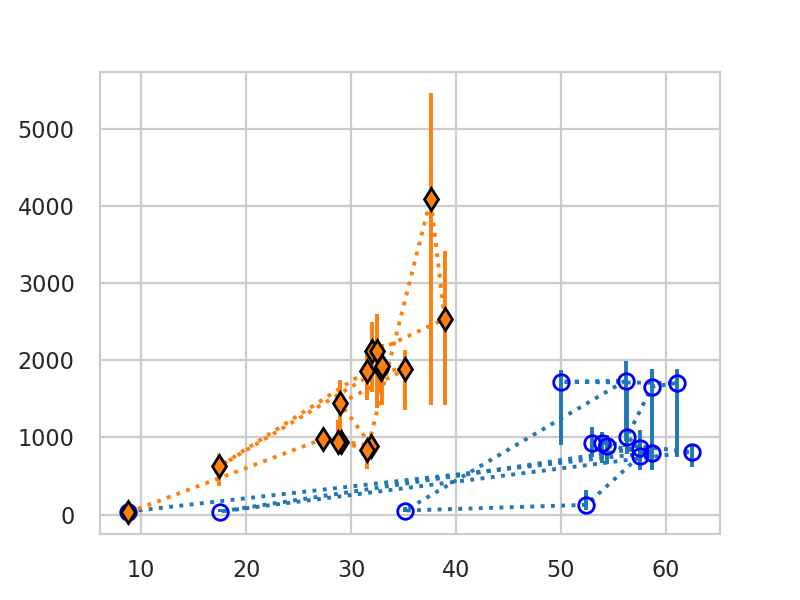

<IPython.core.display.Javascript object>


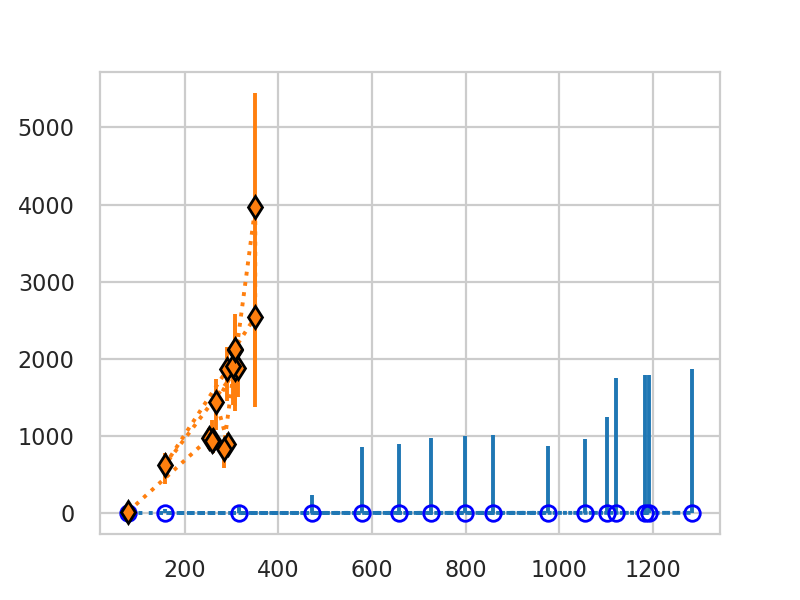

In [289]:
plt.figure(figsize=(4, 3))
df = plot_latency_vs_throughput(lat, 'collisions_zipf_1', 'set', fmt='o:', markeredgecolor='b', markeredgewidth=1, markerfacecolor='none')
df = plot_latency_vs_throughput(lat, 'no_booster_zipf_1', 'set', fmt='d:', markeredgecolor='k', markeredgewidth=1)

plt.figure(figsize=(4, 3))
df = plot_latency_vs_throughput(lat, 'collisions_zipf_1', 'get', fmt='o:', markeredgecolor='b', markeredgewidth=1, markerfacecolor='none')
df = plot_latency_vs_throughput(lat, 'no_booster_zipf_1', 'get', fmt='d:', markeredgecolor='k', markeredgewidth=1)

In [261]:
def plot_vs_rate(df, experiment, pkt_type, mult = 1, color=None, *args, **kwargs):
    df = df[df.experiment == experiment]
    df = df[~df.value.isna()]
    df = df[df.type == pkt_type]
    df = df.assign(value = df.value * mult)
    group = df.groupby('rate')
    stats = get_pctiles(group)
    req_rates = (50.000 / (group.time.max() - group.time.min())).rename('req_rate')
    stats = pd.concat([req_rates, stats], axis=1)
    
    plt.fill_between(stats.req_rate, stats.low, stats.high, alpha=.2, facecolor=color)
    handle = plt.plot(stats.req_rate, stats.med, *args, **kwargs)
    
    plt.xlabel("Rate (kReq/s)")
    return handle

<IPython.core.display.Javascript object>


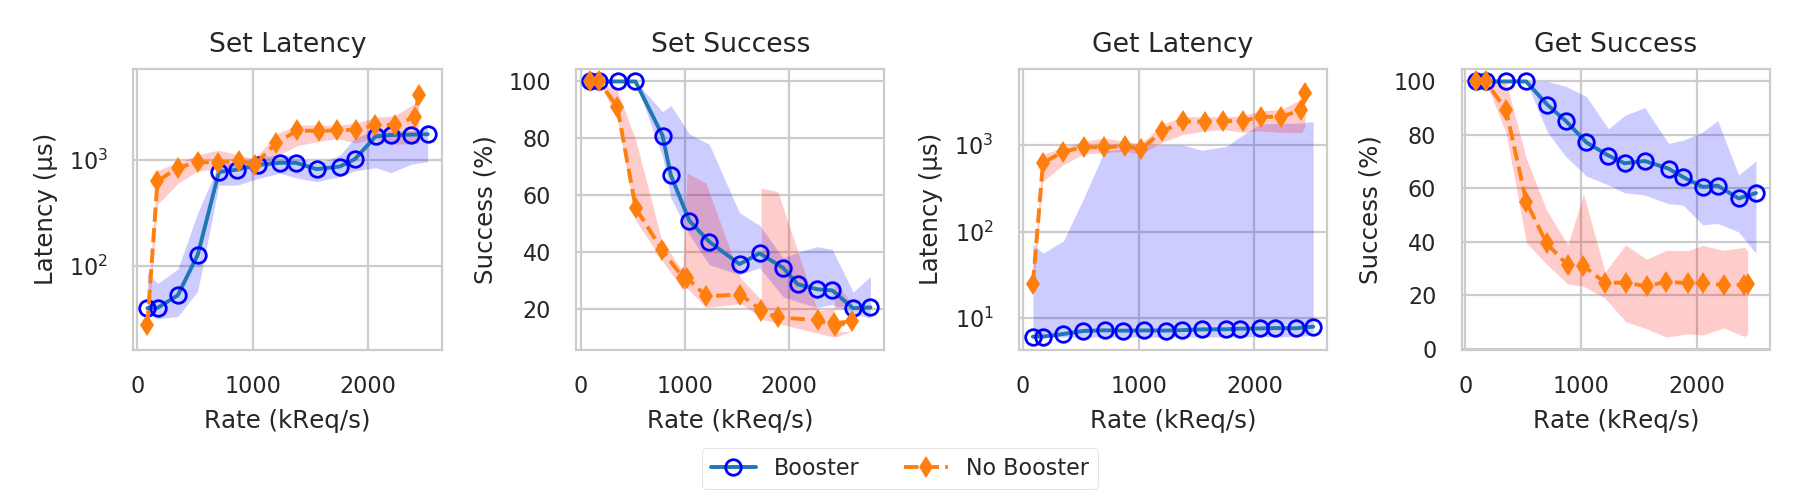

In [326]:
import matplotlib.gridspec as gridspec

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(9, 2.5))

bcol = 'b'
nbcol = 'r'

lat_args = dict(
    mult=1e6
)

succ_args = dict(
    mult = 100
)

b_args = dict(
    color=bcol,
    marker = 'o',
    markerfacecolor='none',
    markeredgecolor=bcol,
    markeredgewidth=1,
)

nb_args = dict(
    color = nbcol,
    marker = 'd',
    linestyle= '--'
)

plt.sca(ax1)
plot_vs_rate(lat, BOOST, 'set', **lat_args, **b_args)
plot_vs_rate(lat, NOBOOST, 'set', **lat_args, **nb_args)
ax1.set_title("Set Latency")
ax1.set_ylabel("Latency (µs)")

plt.sca(ax2)
plot_vs_rate(succ, BOOST, 'set', **succ_args, **b_args)
plot_vs_rate(succ, NOBOOST, 'set', **succ_args, **nb_args)
ax2.set_title("Set Success")
ax2.set_ylabel("Success (%)")
ax1.set_yscale('log')

plt.sca(ax3)
plot_vs_rate(lat, BOOST, 'get', **lat_args, **b_args)
plot_vs_rate(lat, NOBOOST, 'get',**lat_args, **nb_args)
ax3.set_title("Get Latency")
ax3.set_ylabel("Latency (µs)")

plt.sca(ax4)
h1 = plot_vs_rate(succ, BOOST, 'get', **succ_args, **b_args)
h2 = plot_vs_rate(succ, NOBOOST, 'get', **succ_args, **nb_args)
ax4.set_title("Get Success")
ax4.set_ylabel("Success (%)")
ax3.set_yscale('log')


plt.tight_layout()
plt.figlegend(h1+h2, ['Booster', 'No Booster'], loc='lower center', ncol=2)
plt.subplots_adjust(bottom=.3)

plt.savefig("memcached_metrics.pdf")